<newline>.
<newline>
<center>
    <b>
        <font size="12">
            Child mortality prediction
        </font>
    </b>
</center>

# Table of Contents:
* [Problem formulation](#problem-formulation)
* [Data preprocessing](#data-preprocessing)
* [Data correlation analysis](#data-correlation-analysis)
* [Data standardization](#data-standardization)
* [Data visualization](#data-vizualization)

## Imports

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import pmdarima as pm
from typing import List
import warnings
warnings.filterwarnings('ignore')

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

## Functions
<br><div style="text-align: justify;">
&emsp;&emsp;The following functions have been consolidated in one place and have been used for data processing and analysis.
</div>

In [2]:
def plot_global_map(df:pd.DataFrame, year:int, continents: List[str] = list(set(countries.continent)), ax=None):
    year = "{}".format(year)
    title = get_dataframe_name(df) + " " + year
    df = countries[countries['continent'].isin(continents)].set_index('name').join(df.set_index('country'))
    plot_global_map_figure(df=df, year=year, title=title, ax=ax)
    
def plot_global_map_figure(df: pd.DataFrame, year: str, title: str, ax):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 6))
    
    df.plot(column=year, cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.set_title(title)
#     if ax is None:
    vmin = df[year].min()
    vmax = df[year].max()
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.tight_layout()
    plt.colorbar(sm)

def plot_global_map_subplot(df_list: List[pd.DataFrame], year: int, continents: List[str] = list(set(countries.continent))):
    n_plots = len(df_list)
    fig, axes = plt.subplots(nrows=n_plots, ncols=1, figsize=(n_plots*5, 20))
    
    for i, df in enumerate(df_list):
        plot_global_map(df=df, year=year, ax=axes[i])
    
    plt.tight_layout()
    plt.show()
    
def get_dataframe_name(df: pd.DataFrame):
    for name, obj in globals().items():
        if obj is df:
            return name

# <a id='problem-formulation'></a> Problem formulation

<br><div style="text-align: justify;">
&emsp;&emsp;The problem involves predicting child mortality based on factors from multiple domains of life. In this context, a dataset has been selected that contains information on various factors that potentially influence child mortality. The goal is to develop a predictive model that can estimate the risk of death in children based on these factors.

&emsp;&emsp;The project also has the potential to reduce the impact of factors in the future.
</div>

## Data source:

<br><div style="text-align: justify;">
&emsp;&emsp;The data has been obtained from the Gapminder website [https://www.gapminder.org/data/]. Gapminder is a non-profit organization that collects and provides a wide range of global development data. They offer a comprehensive database that covers various indicators related to population, health, education, economy, and more. The data provided by Gapminder is widely used for research, analysis, and visualizations to gain insights into global trends and patterns.
</div>

## Loading data:

In [3]:
original_data = {os.path.splitext(os.path.basename(file_name))[0] : pd.read_csv(file_name) for file_name in glob.glob('original_data/*')}   

# predicted values
child_mortality_df = original_data["child_mortality_0_5_year_olds_dying_per_1000_born"]

# explanatory data
food_supply_df = original_data["food_supply_kilocalories_per_person_and_day"]
med_beds_df = original_data["sh_med_beds_zs"]
co2_emission_df = original_data["co2_emissions_tonnes_per_person"]
gender_equality_df = original_data["gendereq_idea"]

* <b><i>child_mortality_0_5_year_olds_dying_per_1000_born</i></b>

    <div style="text-align: justify;">
    &emsp;&emsp;Death of children under five years of age per 1,000 live births. 
    The data contains information on 196 countries spanning from 1800 to 2100. It is a combination of data from three sources:
    <br><br> 
    &emsp;&emsp;For the period from 1800 to 1950, the data was compiled and documented by Klara Johansson and Mattias Lindgren. The primary sources used were www.mortality.org and the International Historical Statistics series by Brian R Mitchell. Historic estimates of infant mortality rates were transformed into child mortality rates using regression analysis.
    <br><br>
    &emsp;&emsp;From 1950 to 2016, the data is sourced from the UNIGME (United Nations Inter-agency Group for Child Mortality Estimation) collaboration project involving UNICEF, WHO, UN Population Division, and the World Bank. The project released new estimates of child mortality on September 19, 2019, available at www.childmortality.org. This dataset includes estimates for the majority of countries, covering the years from 1970 to 2018, with some countries having data going back to 1960 and a smaller percentage reaching back to 1950.
    <br><br>
    &emsp;&emsp;From 1950 to 2100, the data is obtained from the UN POP (United Nations World Population Prospects) report for 2019. The annual data on child mortality rates is found in the WPP2019_INT_F01_ANNUAL_DEMOGRAPHIC_INDICATORS.xlsx file.
    </div><br>
            
* <b><i>food_supply_kilocalories_per_person_and_day</i></b>

    <div style="text-align: justify;">
    &emsp;&emsp;Calories measures the energy content of the food. The required intake varies, but it is normally in the range of 1500-3000 kilocalories per day. The data contains information on 178 countries.
    <br><br>
    &emsp;&emsp;The data comes from FAOSTAT, which collects food statistics gathered by the Food and Agriculture Organization of the United Nations (FAO). It includes information on agricultural production, food consumption, trade, prices, food stocks, and other aspects related to agriculture and food. The data is collected from various countries worldwide and is used for analysis, monitoring trends, planning food policies, and supporting decisions related to agriculture and food at national and international levels.
    </div><br>

* <b><i>sh_med_beds_zs</i></b>

    <div style="text-align: justify;">
    &emsp;&emsp;The data is sourced from the World Health Organization, supplemented by country data. The data provides information up to the year 2019 on the number of medical beds per 1000 people.
    </div><br>
    
* <b><i>co2_emissions_tonnes_per_person</i></b>

    <div style="text-align: justify;">
    &emsp;&emsp;Carbon dioxide emissions (metric tonnes of CO2 per person). The data comes from the CDIAC service, which is currently transitioning to ESS-DIVE. CDIAC has been collecting data for over 30 years until 2018. The transition process is managed by ESS-DIVE, which is part of the United States Department of Energy. ESS-DIVE is maintained by Lawrence Berkeley National Laboratory and supported by the Biological and Environmental Research program of the United States Department of Energy (BER).
    </div><br>
    
* <b><i>gendereq_idea</i></b>

    <div style="text-align: justify;">
    &emsp;&emsp;Two expert-coded indicators from V-Dem were used to operationalize gender equality–power distribution by gender and female participation in civil society organizations—as well as three observational indicators on the ratio between female and male mean years of schooling (GHDx), the proportion of lower chamber female legislators (V-Dem)and the proportion of women in ministerial-level positions (IPU). The five indicators were aggregated into the gender equality sub-component using IRT.1Power distributed by gender 2CSO women’s participation 3.Female vs. male mean years of schooling 4.Lower chamber female legislators 4.Election women in the cabinet
    </div><br>

## DAG:

<br><div style="text-align: justify;">
&emsp;&emsp;The selected parameters with the least mutual correlation and the most impact on the target value have been marked with a red border.
</div>

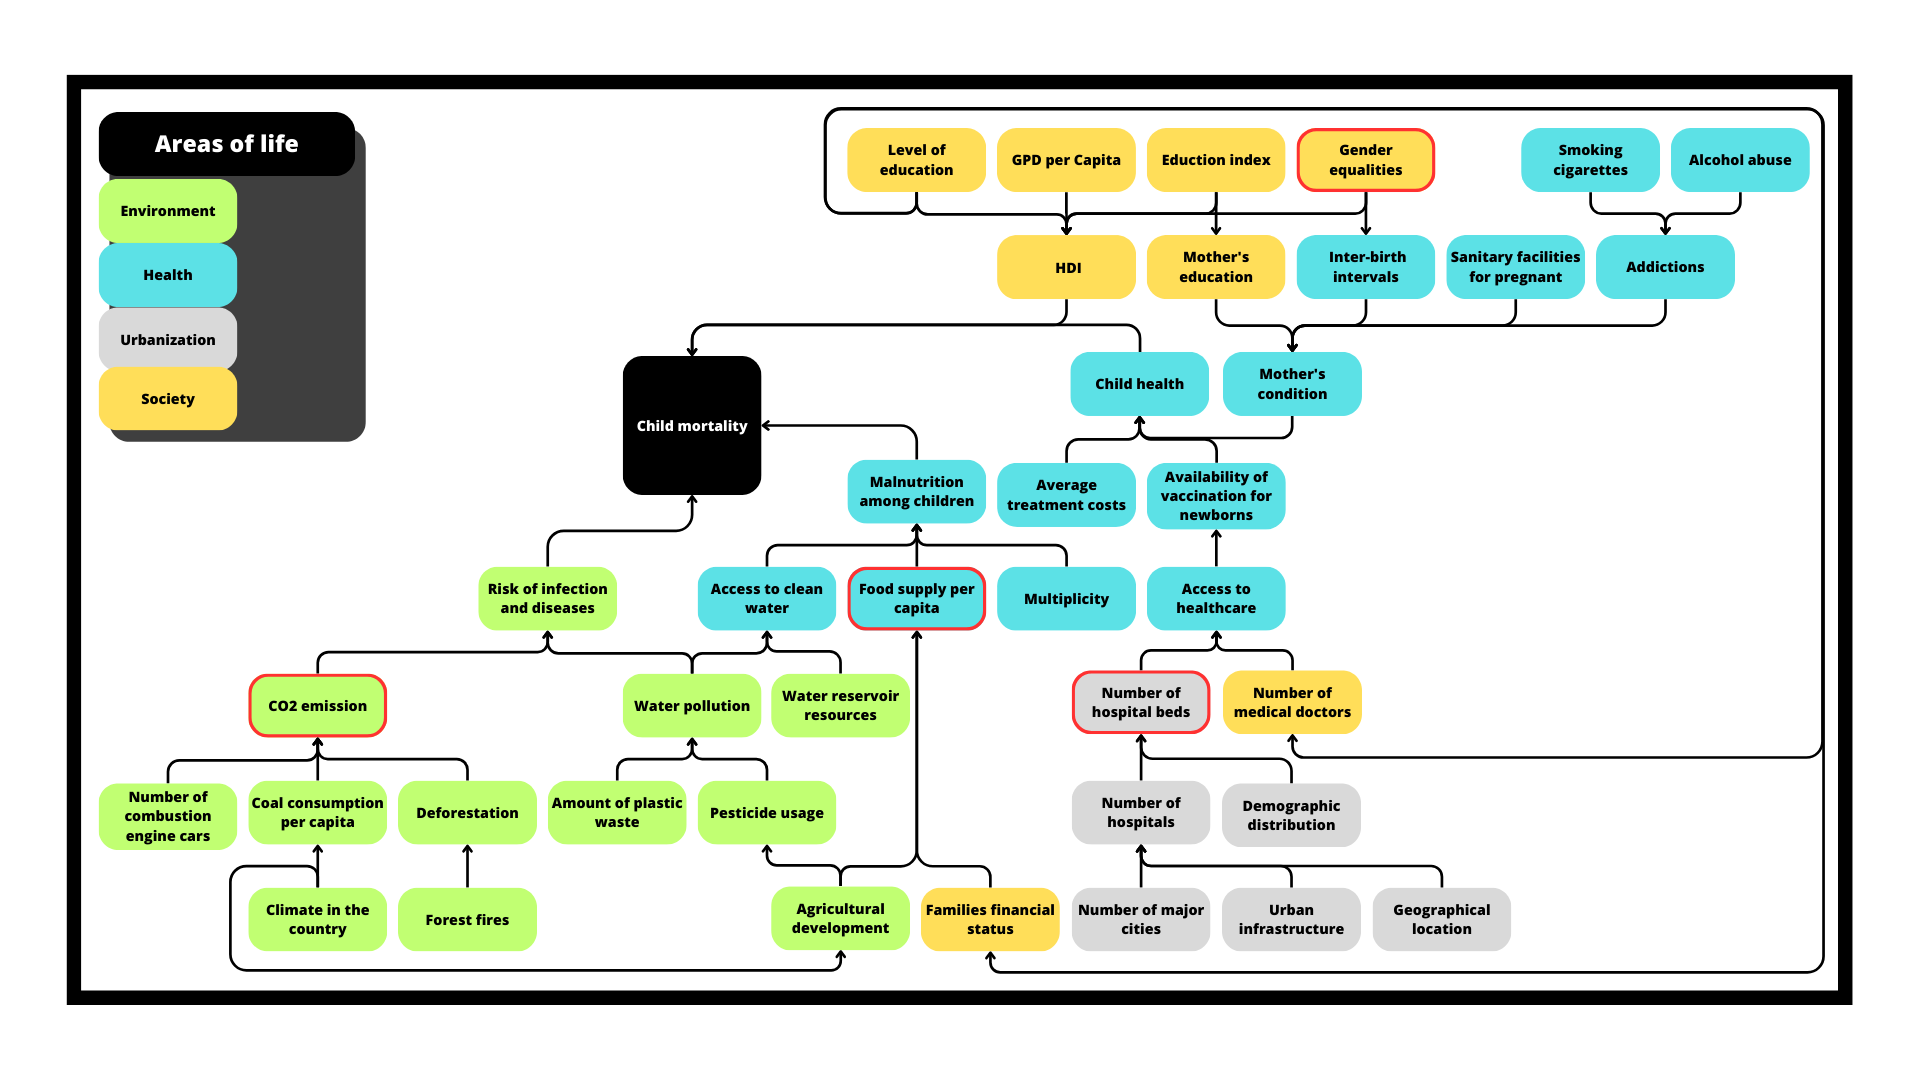

<div style="text-align: justify;">
&emsp;&emsp; Based on the analysis of the problem, we have selected parameters for our DAG in such a way that their interdependence is minimized while still influencing the target variable. Additionally, each parameter is derived from a different area of life. If we were to expand the graph, we might discover some connections between these parameters, but they are relatively distant, as illustrated by our DAG. None of the parameters are a result of any other analyzed parameter.
</div>

# <a id='data-preprocessing'></a>Data Preprocessing
<br><div style="text-align: justify;">
&emsp;&emsp;Due to the large amount of data and variations in data collection methods, the dataset contains numerous missing values. To address this, we selected the year 2019, which had the most complete data. In cases where there were significant missing values, we chose to remove the corresponding data. However, whenever possible, we applied imputation methods, such as ARIMA, to estimate missing data based on previous measurements.
</div>
<br><div style="text-align: justify;">
&emsp;&emsp;The goal was to have the resulting dataset include as many countries as possible, encompassing all the analyzed indicators. Below, we conducted parameter analysis and prepared the data for further analysis.
</div>

In [4]:
years_range = [str(i) for i in range(2000, 2020)]

## Data imputation
<br><div style="text-align: justify;">
&emsp;&emsp;The analyzed data have been examined over the years, thus it was appropriate to apply ARIMA-based imputation. By filling in the missing data in this way, we obtained a complete dataset for model training.
</div>

### child_mortality_0_5_year_olds_dying_per_1000_born

In [5]:
child_mortality_df.columns

Index(['country', '1800', '1801', '1802', '1803', '1804', '1805', '1806',
       '1807', '1808',
       ...
       '2091', '2092', '2093', '2094', '2095', '2096', '2097', '2098', '2099',
       '2100'],
      dtype='object', length=302)

In [6]:
child_mortality_df = child_mortality_df[["country"] + years_range]
child_mortality_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,129.00,125.00,121.00,117.00,113.00,109.00,104.00,100.00,96.00,...,88.00,84.10,80.50,77.00,73.50,70.40,67.50,64.70,62.30,60.10
1,Angola,206.00,200.00,193.00,185.00,176.00,167.00,157.00,148.00,138.00,...,120.00,113.00,105.00,98.40,92.90,88.10,84.00,80.40,77.20,74.50
2,Albania,25.90,24.50,23.10,21.80,20.40,19.20,17.90,16.70,15.50,...,13.30,12.30,11.40,10.70,10.10,9.60,9.27,9.02,8.82,8.68
3,Andorra,6.41,6.16,5.93,5.71,5.49,5.27,5.05,4.84,4.62,...,4.18,3.98,3.79,3.61,3.43,3.27,3.14,3.01,2.89,2.87
4,United Arab Emirates,11.20,10.90,10.60,10.30,10.00,9.73,9.44,9.18,8.93,...,8.48,8.28,8.13,8.00,7.91,7.83,7.76,7.68,7.59,7.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Samoa,21.10,20.40,19.90,19.50,19.20,19.00,18.90,18.90,18.90,...,18.70,18.50,18.30,17.90,17.60,17.20,16.70,16.30,15.80,15.40
193,Yemen,94.90,90.30,85.60,81.10,76.70,72.50,68.40,64.60,61.00,...,56.00,55.10,55.00,55.00,55.00,55.00,55.00,55.00,55.00,54.90
194,South Africa,73.90,75.80,77.40,79.10,79.40,78.50,76.00,71.00,64.80,...,52.50,46.70,43.30,41.20,39.50,37.70,36.60,35.30,33.80,32.90
195,Zambia,162.00,153.00,142.00,130.00,119.00,110.00,101.00,95.40,90.40,...,80.30,77.20,74.30,70.70,66.90,64.60,62.00,59.40,57.80,56.10


In [7]:
child_mortality_df[child_mortality_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019


<div style="text-align: justify;">
&emsp;&emsp;The way the data was collected ensures that the processed dataset does not contain any missing values. All values for the analyzed countries are filled in during data collection by Gapminder.
</div>

### food_supply_kilocalories_per_person_and_day

In [8]:
food_supply_df.columns

Index(['country', '1961', '1962', '1963', '1964', '1965', '1966', '1967',
       '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976',
       '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985',
       '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994',
       '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018'],
      dtype='object')

In [9]:
food_supply_df = food_supply_df[["country"] + years_range[:-1]]

In [10]:
food_supply_df[food_supply_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
3,Netherlands Antilles,3080.0,3050.0,3070.0,3060.0,3080.0,3090.0,3090.0,3070.0,3080.0,3100.0,3110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Bermuda,2650.0,2610.0,2580.0,2490.0,2460.0,2520.0,2590.0,2630.0,2700.0,2720.0,2680.0,2650.0,2650.0,2670.0,NaN,NaN,NaN,NaN,NaN
24,Brunei,2800.0,2880.0,2930.0,2980.0,3000.0,2980.0,2970.0,2920.0,2910.0,2890.0,2890.0,2940.0,2970.0,2990.0,NaN,NaN,NaN,NaN,NaN
29,Czechoslovakia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,Montenegro,NaN,NaN,NaN,NaN,NaN,NaN,3280.0,3410.0,3480.0,3490.0,3460.0,3480.0,3370.0,3490.0,3380.0,3420.0,3480.0,3500.0,3500.0
139,Serbia and Montenegro,2650.0,2610.0,2630.0,2700.0,2700.0,2700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,Serbia,NaN,NaN,NaN,NaN,NaN,NaN,2750.0,2710.0,2720.0,2760.0,2730.0,2730.0,2720.0,2730.0,2810.0,2790.0,2810.0,2820.0,2830.0
167,USSR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,Yugoslavia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="text-align: justify;">
&emsp;&emsp;For Serbia and Montenegro, the values of food supply were split into two separate countries after 2005.
</div>

In [11]:
serbia_montenegro_df = food_supply_df[food_supply_df['country'].isin(['Montenegro', 'Serbia and Montenegro', 'Serbia'])]
montenegro = serbia_montenegro_df.iloc[0].combine_first(serbia_montenegro_df.iloc[1])
serbia = serbia_montenegro_df.iloc[2].combine_first(serbia_montenegro_df.iloc[1])

In [12]:
food_supply_df = food_supply_df.drop(food_supply_df[food_supply_df['country'].isin(['Montenegro', 'Serbia and Montenegro', 'Serbia'])].index)

In [13]:
food_supply_df = food_supply_df.append(montenegro, ignore_index=True)
food_supply_df = food_supply_df.append(serbia, ignore_index=True)

In [14]:
food_supply_df[food_supply_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
3,Netherlands Antilles,3080.0,3050.0,3070.0,3060.0,3080.0,3090.0,3090.0,3070.0,3080.0,3100.0,3110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Bermuda,2650.0,2610.0,2580.0,2490.0,2460.0,2520.0,2590.0,2630.0,2700.0,2720.0,2680.0,2650.0,2650.0,2670.0,NaN,NaN,NaN,NaN,NaN
24,Brunei,2800.0,2880.0,2930.0,2980.0,3000.0,2980.0,2970.0,2920.0,2910.0,2890.0,2890.0,2940.0,2970.0,2990.0,NaN,NaN,NaN,NaN,NaN
29,Czechoslovakia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,USSR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172,Yugoslavia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="text-align: justify;">
&emsp;&emsp;There is a lack of data for more than 5 years in the past, therefore, we decide not to fill them and discard them in further analysis.
</div>

In [15]:
food_supply_df = food_supply_df.dropna()

In [16]:
food_supply_df[food_supply_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018


<div style="text-align: justify;">
&emsp;&emsp;The data is up to the year 2018 and does not contain any missing values. We filled in the year 2019 using ARIMA
</div>

In [17]:
df = food_supply_df.drop(["country"], axis = 1)

In [18]:
pred = []
for _, row in df.iterrows():
    auto_arima=pm.auto_arima(row, start_p = 0, start_q = 0, max_p = 12, max_q = 12, m = 12, start_P = 0, start_Q = 0, seasonal = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)
    prediction = pd.DataFrame(auto_arima.predict(n_periods=1))
    pred.append(prediction)

In [19]:
for i in range(len(pred)):
    pred[i] = float(int(pred[i].iat[0, 0]))

In [20]:
food_supply_df["2019"] = pred

### sh_med_beds_zs

In [21]:
med_beds_df.columns

Index(['country', '1960', '1961', '1962', '1963', '1964', '1965', '1966',
       '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975',
       '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984',
       '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'],
      dtype='object')

In [22]:
med_beds_df = med_beds_df [["country"] + years_range]

In [23]:
med_beds_df.isna().sum().tail(5)

2015     94
2016     97
2017    103
2018    165
2019    193
dtype: int64

In [24]:
med_beds_2019 = med_beds_df[med_beds_df['2019'].notna()]

<div style="text-align: justify;">
&emsp;&emsp;There are only 8 rows with a value in 2019 that are retained in the result.
</div>

In [25]:
med_beds_df = med_beds_df [["country"] + years_range[:-2]]
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,0.30,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,0.42,0.43,0.44,0.53,0.53,0.50,0.50,0.50,0.39
1,Angola,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,NaN,3.01,2.99,2.88,2.88,2.89,NaN,NaN,NaN,NaN
3,Andorra,3.20,2.59,NaN,3.30,NaN,2.70,2.60,2.60,NaN,2.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,1.93,1.93,1.07,1.07,1.15,0.01,1.10,1.36,1.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,Samoa,3.30,NaN,1.50,2.04,NaN,1.00,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,Yemen,0.59,0.59,0.59,0.59,0.59,0.61,0.70,0.70,0.70,0.70,0.72,0.70,0.72,0.67,0.71,0.71,0.71,0.71
198,South Africa,NaN,NaN,3.10,NaN,2.87,2.80,NaN,2.41,2.39,NaN,2.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,Zambia,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.90,NaN,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
med_beds_df = med_beds_df[med_beds_df.isna().sum(axis=1) < 9]

<div style="text-align: justify;">
&emsp;&emsp;Countries that have more than 9 missing values in the analyzed range are not considered for further analysis.
</div>

In [27]:
med_beds_df = med_beds_df.T
med_beds_df = med_beds_df.fillna(method='bfill')
med_beds_df = med_beds_df.fillna(method='ffill')
med_beds_df = med_beds_df.T
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,0.3,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,0.42,0.43,0.44,0.53,0.53,0.5,0.5,0.5,0.39
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,3.01,3.01,2.99,2.88,2.88,2.89,2.89,2.89,2.89,2.89
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,1.93,1.93,1.07,1.07,1.15,0.01,1.1,1.36,1.38
5,Argentina,4.1,4.0,4.0,4.0,4.0,4.0,4.5,4.5,4.5,4.5,4.5,4.39,4.59,4.78,4.84,4.96,4.95,4.99
6,Armenia,6.44,5.03,4.35,4.42,4.44,4.46,4.42,4.07,3.82,3.72,3.73,3.74,4.05,4.06,4.16,4.2,4.2,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,United States,3.49,3.47,3.39,3.33,3.26,3.2,3.18,3.14,3.13,3.08,3.05,2.97,2.93,2.89,2.83,2.8,2.77,2.87
190,Uzbekistan,5.33,5.34,5.54,5.48,5.26,5.19,5.12,4.83,4.67,4.58,4.44,4.32,4.19,3.99,3.98,3.98,3.98,3.98
191,St. Vincent and the Grenadines,4.7,4.7,4.5,4.5,4.5,4.5,3.0,3.0,2.6,2.6,2.6,2.52,2.41,2.41,2.4,4.33,4.32,4.32
194,Vietnam,2.34,2.4,1.4,2.8,2.8,2.34,2.66,2.9,2.9,3.1,2.91,2.5,2.5,3.18,2.6,2.6,2.6,2.6


In [28]:
df = med_beds_df.drop(["country"], axis = 1)

In [29]:
pred = []
for _, row in df.iterrows():
    auto_arima=pm.auto_arima(row, start_p = 0, start_q = 0, max_p = 12, max_q = 12, m = 12, start_P = 0, start_Q = 0, seasonal = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)
    prediction = pd.DataFrame(auto_arima.predict(n_periods=2))
    pred.append(prediction)

In [30]:
pred_2018 = []
pred_2019 = []
for i in range(len(pred)):
    pred_2018.append(round(pred[i].iat[0, 0], 2))
    pred_2019.append(round(pred[i].iat[1, 0], 2))

In [31]:
med_beds_df["2018"] = pred_2018
med_beds_df["2019"] = pred_2019

<div style="text-align: justify;">
&emsp;&emsp;Replace a predicted values in 2019 for 8 countries by oryginal data.
</div>

In [32]:
common_countries = list(set(med_beds_df['country']).intersection(set(med_beds_2019['country'])))
med_beds_df.loc[med_beds_df['country'].isin(common_countries), '2019'] = med_beds_2019.loc[:, '2019']

### co2_emissions_tonnes_per_person

In [33]:
co2_emission_df = co2_emission_df[["country"] + years_range[:-1]]

In [34]:
co2_emission_df[co2_emission_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
172,Timor-Leste,NaN,NaN,0.175,0.17,0.181,0.177,0.177,0.177,0.191,0.212,0.215,0.221,0.259,0.385,0.437,0.42,0.406,0.409,0.412


In [35]:
co2_emission_df.loc[co2_emission_df['country'] == 'Timor-Leste', ['2000']] = co2_emission_df.loc[co2_emission_df['country'] == 'Timor-Leste', '2002']
co2_emission_df.loc[co2_emission_df['country'] == 'Timor-Leste', ['2001']] = co2_emission_df.loc[co2_emission_df['country'] == 'Timor-Leste', '2003']
co2_emission_df[co2_emission_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018


In [36]:
df = co2_emission_df.drop(["country"], axis = 1)

In [37]:
pred = []
for _, row in df.iterrows():
    auto_arima=pm.auto_arima(row, start_p = 0, start_q = 0, max_p = 12, max_q = 12, m = 12, start_P = 0, start_Q = 0, seasonal = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)
    prediction = pd.DataFrame(auto_arima.predict(n_periods=1))
    pred.append(prediction)

In [38]:
for i in range(len(pred)):
    pred[i] = float(pred[i].iat[0, 0])

In [39]:
co2_emission_df["2019"] = pred

### gendereq_idea

In [40]:
gender_equality_df = gender_equality_df[["country"] + years_range]

In [41]:
gender_equality_df[gender_equality_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
103,Montenegro,NaN,NaN,NaN,NaN,NaN,NaN,46.8,49.3,49.7,...,50.8,50.9,51.6,51.5,51.6,53.0,54.3,55.1,55.1,55.1
142,South Sudan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31.1,31.1,30.6,28.9,30.6,27.5,28.4,29.6,28.9
154,Timor-Leste,NaN,NaN,44.1,47.1,45.4,45.7,46.5,46.6,46.6,...,45.4,45.4,47.5,47.5,47.7,46.0,43.3,44.8,46.9,48.2


<div style="text-align: justify;">
&emsp;&emsp; The column for the year 2019 does not have any missing data, therefore there is no need for imputing the remaining columns.
</div>

### Summary

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,129.00,125.00,121.00,117.00,113.00,109.00,104.00,100.00,96.00,...,88.00,84.10,80.50,77.00,73.50,70.40,67.50,64.70,62.30,60.10
1,Angola,206.00,200.00,193.00,185.00,176.00,167.00,157.00,148.00,138.00,...,120.00,113.00,105.00,98.40,92.90,88.10,84.00,80.40,77.20,74.50
2,Albania,25.90,24.50,23.10,21.80,20.40,19.20,17.90,16.70,15.50,...,13.30,12.30,11.40,10.70,10.10,9.60,9.27,9.02,8.82,8.68
3,Andorra,6.41,6.16,5.93,5.71,5.49,5.27,5.05,4.84,4.62,...,4.18,3.98,3.79,3.61,3.43,3.27,3.14,3.01,2.89,2.87
4,United Arab Emirates,11.20,10.90,10.60,10.30,10.00,9.73,9.44,9.18,8.93,...,8.48,8.28,8.13,8.00,7.91,7.83,7.76,7.68,7.59,7.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Samoa,21.10,20.40,19.90,19.50,19.20,19.00,18.90,18.90,18.90,...,18.70,18.50,18.30,17.90,17.60,17.20,16.70,16.30,15.80,15.40
193,Yemen,94.90,90.30,85.60,81.10,76.70,72.50,68.40,64.60,61.00,...,56.00,55.10,55.00,55.00,55.00,55.00,55.00,55.00,55.00,54.90
194,South Africa,73.90,75.80,77.40,79.10,79.40,78.50,76.00,71.00,64.80,...,52.50,46.70,43.30,41.20,39.50,37.70,36.60,35.30,33.80,32.90
195,Zambia,162.00,153.00,142.00,130.00,119.00,110.00,101.00,95.40,90.40,...,80.30,77.20,74.30,70.70,66.90,64.60,62.00,59.40,57.80,56.10


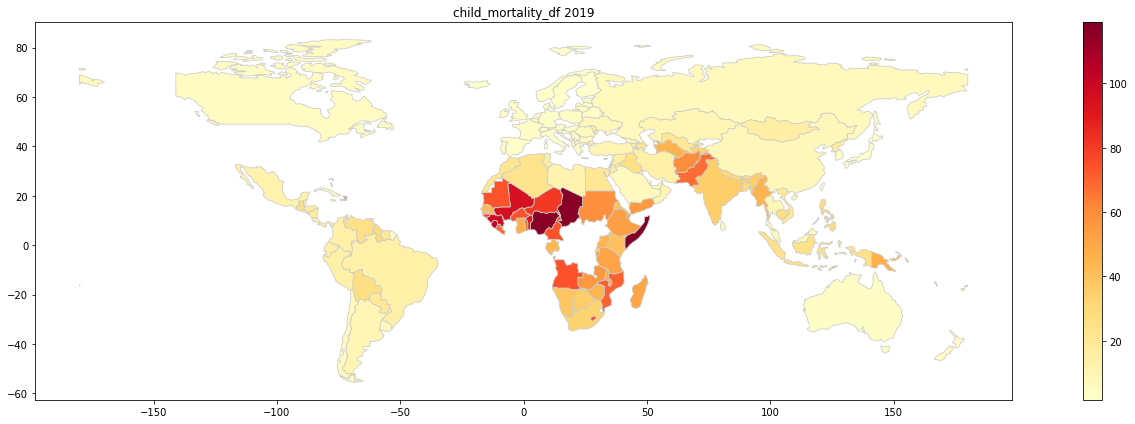

In [42]:
child_mortality_df.to_csv('./analysis_data/child_mortality.csv')
plot_global_map(child_mortality_df, year='2019')
child_mortality_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,1790.0,1740.0,1830.0,1890.0,1970.0,1950.0,1970.0,2050.0,2040.0,...,2100.0,2110.0,2100.0,2090.0,2100.0,2040.0,2030.0,2050.0,2040.0,2040.0
1,Angola,1790.0,1830.0,1920.0,1980.0,2030.0,2080.0,2120.0,2170.0,2250.0,...,2350.0,2410.0,2380.0,2470.0,2420.0,2380.0,2340.0,2370.0,2390.0,2423.0
2,Albania,2730.0,2800.0,2860.0,2770.0,2790.0,2870.0,2860.0,2860.0,2950.0,...,3080.0,3130.0,3180.0,3190.0,3270.0,3280.0,3380.0,3390.0,3360.0,3395.0
4,United Arab Emirates,3300.0,3320.0,3360.0,3340.0,3290.0,3210.0,3200.0,3190.0,3150.0,...,3160.0,3210.0,3230.0,3280.0,3400.0,3410.0,3370.0,3340.0,3310.0,3285.0
5,Argentina,3260.0,3210.0,2980.0,3010.0,3030.0,3110.0,3110.0,3150.0,3160.0,...,3160.0,3160.0,3200.0,3230.0,3250.0,3310.0,3250.0,3270.0,3310.0,3310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,South Africa,2890.0,2910.0,2910.0,2930.0,2940.0,2950.0,2930.0,2920.0,2920.0,...,2990.0,3000.0,3010.0,3020.0,2980.0,2940.0,2920.0,2940.0,2900.0,2892.0
174,Zambia,1870.0,1850.0,1850.0,1900.0,1870.0,1870.0,1840.0,1780.0,1800.0,...,1900.0,1910.0,1920.0,1930.0,2010.0,2030.0,1990.0,1990.0,2000.0,2000.0
175,Zimbabwe,1980.0,2030.0,2020.0,2010.0,2040.0,2030.0,2120.0,2110.0,2090.0,...,2170.0,2200.0,2200.0,2110.0,1990.0,1910.0,1890.0,1890.0,1910.0,1943.0
176,Montenegro,2650.0,2610.0,2630.0,2700.0,2700.0,2700.0,3280.0,3410.0,3480.0,...,3460.0,3480.0,3370.0,3490.0,3380.0,3420.0,3480.0,3500.0,3500.0,3500.0


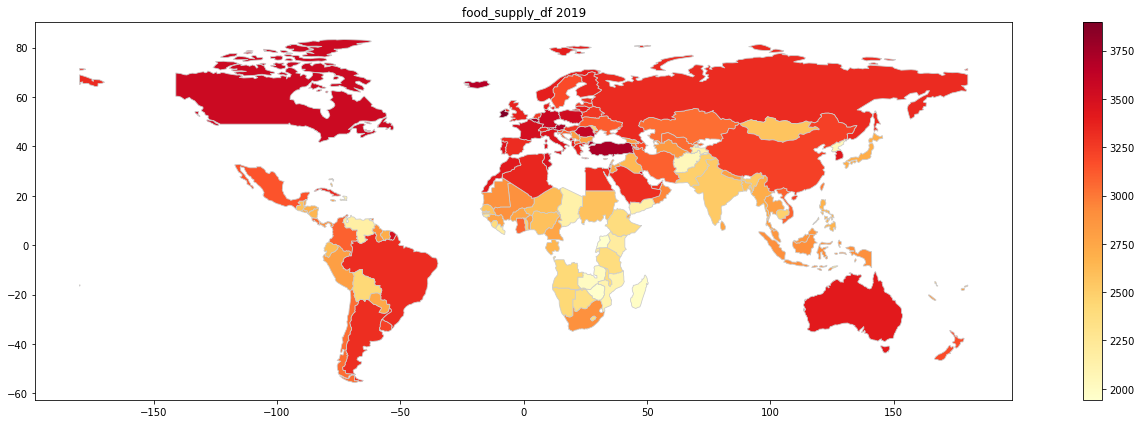

In [43]:
food_supply_df.to_csv('./analysis_data/food_supply.csv')
plot_global_map(food_supply_df, year='2019')
food_supply_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.3,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,...,0.43,0.44,0.53,0.53,0.5,0.5,0.5,0.39,0.39,0.39
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,3.01,...,2.99,2.88,2.88,2.89,2.89,2.89,2.89,2.89,2.87,2.85
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,...,1.93,1.07,1.07,1.15,0.01,1.1,1.36,1.38,1.38,1.38
5,Argentina,4.1,4.0,4.0,4.0,4.0,4.0,4.5,4.5,4.5,...,4.5,4.39,4.59,4.78,4.84,4.96,4.95,4.99,5.04,5.09
6,Armenia,6.44,5.03,4.35,4.42,4.44,4.46,4.42,4.07,3.82,...,3.73,3.74,4.05,4.06,4.16,4.2,4.2,4.2,4.25,4.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,United States,3.49,3.47,3.39,3.33,3.26,3.2,3.18,3.14,3.13,...,3.05,2.97,2.93,2.89,2.83,2.8,2.77,2.87,2.83,2.80
190,Uzbekistan,5.33,5.34,5.54,5.48,5.26,5.19,5.12,4.83,4.67,...,4.44,4.32,4.19,3.99,3.98,3.98,3.98,3.98,3.92,3.84
191,St. Vincent and the Grenadines,4.7,4.7,4.5,4.5,4.5,4.5,3.0,3.0,2.6,...,2.6,2.52,2.41,2.41,2.4,4.33,4.32,4.32,4.23,4.15
194,Vietnam,2.34,2.4,1.4,2.8,2.8,2.34,2.66,2.9,2.9,...,2.91,2.5,2.5,3.18,2.6,2.6,2.6,2.6,2.62,2.62


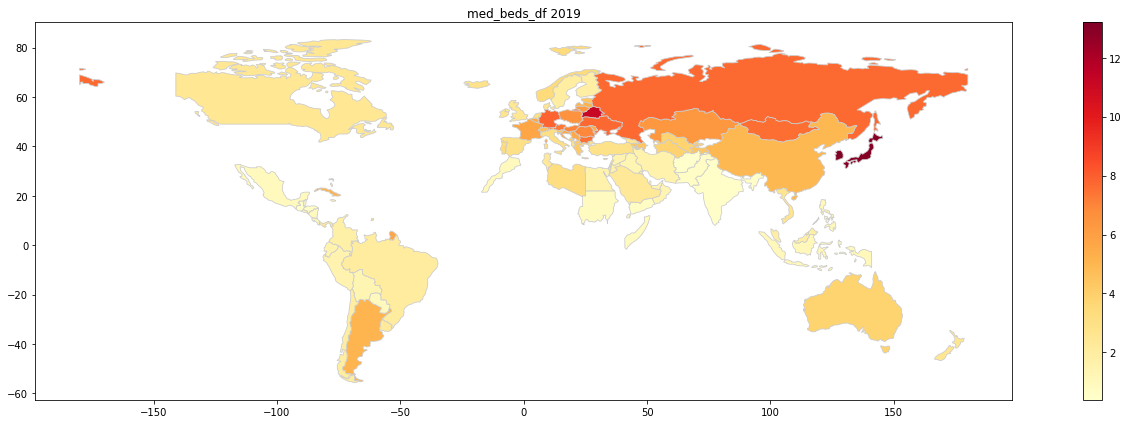

In [44]:
med_beds_df.to_csv('./analysis_data/med_beds.csv')
plot_global_map(med_beds_df, year='2019')
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.037,0.0376,0.0471,0.0509,0.0368,0.0515,0.0622,0.0838,0.152,...,0.290,0.406,0.345,0.280,0.253,0.262,0.245,0.247,0.254,0.254000
1,Angola,0.581,0.5710,0.7200,0.4960,0.9980,0.9790,1.1000,1.2000,1.180,...,1.240,1.250,1.350,1.280,1.640,1.220,1.180,1.140,1.120,1.128767
2,Albania,0.966,1.0300,1.2000,1.3800,1.3400,1.3800,1.2700,1.2900,1.460,...,1.560,1.790,1.690,1.690,1.900,1.600,1.570,1.610,1.590,1.590000
3,Andorra,8.020,7.7900,7.5900,7.3200,7.3600,7.3000,6.7500,6.5200,6.430,...,6.120,5.870,5.920,5.900,5.830,5.970,6.070,6.270,6.120,6.014444
4,United Arab Emirates,35.700,30.5000,24.1000,28.5000,27.5000,25.0000,23.0000,21.6000,21.700,...,18.300,18.900,23.800,23.700,24.200,20.700,21.700,21.100,21.400,21.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Samoa,0.820,0.8360,0.8310,0.8680,0.8420,0.8980,0.9120,0.9470,0.980,...,1.010,1.080,1.050,1.040,1.090,1.210,1.260,1.290,1.320,1.347778
190,Yemen,0.832,0.8950,0.8440,0.9010,0.9550,0.9850,1.0200,0.9740,1.010,...,1.000,0.849,0.747,0.994,0.937,0.480,0.377,0.363,0.356,0.412083
191,South Africa,8.420,8.1600,7.7300,8.6600,9.5000,8.6900,9.2200,9.4700,9.940,...,9.160,9.160,8.770,8.530,8.860,8.350,8.460,8.120,8.100,8.296546
192,Zambia,0.172,0.1760,0.1790,0.1850,0.1820,0.1890,0.1830,0.1490,0.164,...,0.189,0.199,0.241,0.252,0.277,0.271,0.296,0.304,0.302,0.309222


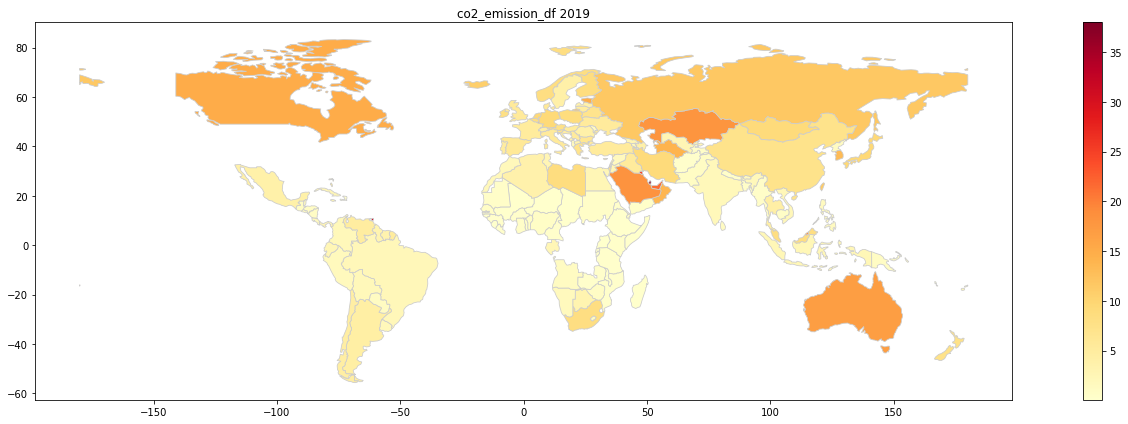

In [45]:
co2_emission_df.to_csv('./analysis_data/co2_emission.csv')
plot_global_map(co2_emission_df, year='2019')
co2_emission_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.0,3.25,26.2,30.3,32.0,34.0,34.0,34.6,33.4,...,34.0,34.0,34.0,34.0,34.0,34.00,31.2,32.8,33.8,33.8
1,Angola,37.6,37.60,40.7,45.0,45.2,45.2,45.2,45.2,44.4,...,46.9,49.0,48.9,50.6,50.6,50.80,49.3,51.8,51.8,52.1
2,Albania,50.6,53.00,53.8,55.5,53.8,56.5,56.5,58.1,55.5,...,57.8,57.8,58.0,58.5,60.2,60.40,62.1,61.0,61.2,62.0
3,United Arab Emirates,27.6,31.20,28.9,28.9,30.2,34.7,32.8,37.1,40.0,...,41.6,41.3,41.9,41.9,41.9,44.50,36.9,40.6,40.6,41.1
4,Argentina,68.8,71.30,71.3,73.5,75.6,75.6,73.9,77.6,76.0,...,77.6,77.6,77.6,75.6,75.6,76.10,76.5,77.1,74.2,75.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Vanuatu,51.0,48.80,48.9,50.9,49.2,49.4,49.4,48.3,48.3,...,48.5,48.5,48.2,48.4,48.4,48.10,48.4,45.1,46.0,46.0
168,Yemen,14.8,16.60,14.8,14.8,16.7,17.4,17.4,17.4,15.6,...,15.6,16.2,16.2,18.0,17.1,9.59,18.8,14.1,16.1,15.4
169,South Africa,67.0,67.10,67.1,62.5,63.4,65.3,65.3,65.3,65.3,...,65.7,65.7,65.7,62.3,62.7,62.70,62.8,62.7,62.7,63.6
170,Zambia,48.5,48.60,48.6,48.6,48.6,47.5,47.9,48.8,48.8,...,49.8,48.3,49.5,50.5,49.5,49.00,49.0,48.4,53.8,55.9


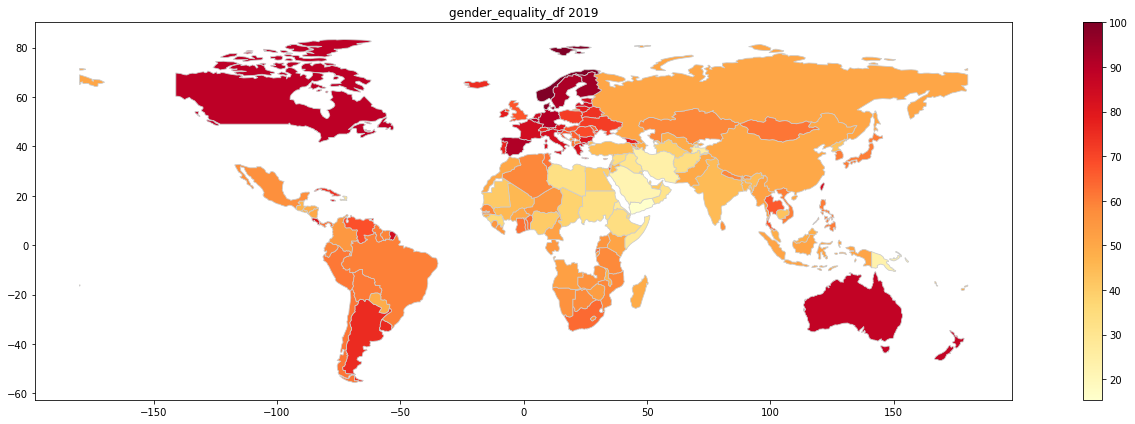

In [46]:
gender_equality_df.to_csv('./analysis_data/gender_equality.csv')
plot_global_map(gender_equality_df, year='2019')
gender_equality_df

<div style="text-align: justify;">
&emsp;&emsp; We are checking how many countries exist for which data is available for all 5 analyzed indicators
</div>

In [47]:
countries_names = set(child_mortality_df['country']).intersection(food_supply_df['country'], med_beds_df['country'], co2_emission_df['country'], gender_equality_df['country'])
print("Number of data intersection countries: ", len(countries_names))
print("\n", countries_names)

Number of data intersection countries:  100

 {'Sudan', 'Austria', 'North Macedonia', 'Mongolia', 'Italy', 'Iceland', 'Switzerland', 'New Zealand', 'Malaysia', 'Panama', 'Paraguay', 'Jamaica', 'Iran', 'Israel', 'Germany', 'Dominican Republic', 'United Arab Emirates', 'Spain', 'Finland', 'Trinidad and Tobago', 'Azerbaijan', 'Colombia', 'United Kingdom', 'Latvia', 'Brazil', 'Ecuador', 'Sweden', 'Canada', 'Oman', 'Japan', 'Armenia', 'Chile', 'Lithuania', 'Czech Republic', 'Belarus', 'Portugal', 'Albania', 'Guatemala', 'Bosnia and Herzegovina', 'Iraq', 'Denmark', 'Greece', 'Malta', 'Australia', 'Ireland', 'Turkmenistan', 'Afghanistan', 'Poland', 'Yemen', 'United States', 'Kyrgyz Republic', 'Hungary', 'Russia', 'Bolivia', 'Kazakhstan', 'Honduras', 'Egypt', 'Ukraine', 'Djibouti', 'Turkey', 'South Korea', 'Cyprus', 'Nicaragua', 'Belgium', 'Croatia', 'France', 'Costa Rica', 'Morocco', 'Romania', 'Uruguay', 'Estonia', 'Netherlands', 'Tajikistan', 'Vietnam', 'Uzbekistan', 'Kuwait', 'Luxembourg',

## <a id='data-correlation-analysis'></a> Data correlation analysis

<br><div style="text-align: justify;">
&emsp;&emsp;Checking correlation is not the best indicator for analyzing relationships between parameters. In our project, we use correlation analysis to see how the indicators relate to the overall knowledge presented in the DAG.
</div>

In [48]:
dataframes = {
    'child_mortality': child_mortality_df,
    'food_supply': food_supply_df,
    'med_beds': med_beds_df,
    'co2_emission': co2_emission_df,
    'gender_equality': gender_equality_df
}

for name, df in dataframes.items():
    df.rename(columns={'2019': name}, inplace=True)
merged_df = child_mortality_df[['country']].copy()

for name, df in dataframes.items():
    merged_df = merged_df.merge(df[['country', name]], on='country')


In [49]:
merged_df.to_csv('./analysis_data/analysis_data.csv')

In [50]:
correlations = merged_df.iloc[:, 1:].corrwith(merged_df['child_mortality'])
print(correlations)

child_mortality    1.000000
food_supply       -0.680821
med_beds          -0.434219
co2_emission      -0.343157
gender_equality   -0.618480
dtype: float64


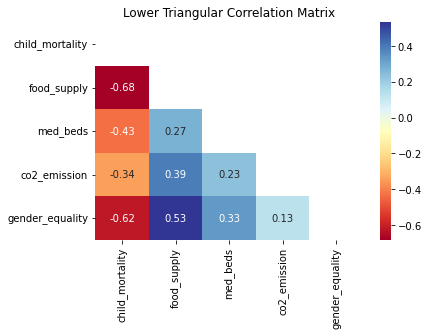

In [51]:
correlation_matrix = merged_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(data=correlation_matrix, mask=mask, annot=True, cmap='RdYlBu')
plt.title('Lower Triangular Correlation Matrix')
plt.show()

<div style="text-align: justify;">
&emsp;&emsp;An inverse correlation has been detected between the variables and the "child_mortality" indicator with a value greater than -0.35, <b>indicating that as the values increase, the "child_mortality" indicator decreases</b>. However, the variable "child_mortality" is also mutually correlated with other variables when the value is less than 0.41. For an optimal model, the explanatory variables should have weak correlation among themselves but a strong correlation with the variable we want to predict.
</div>

## <a id='data-standardization'></a> Data standardization
<br><div style="text-align: justify;">
&emsp;&emsp;Data standardization is used to transform variables in a way that allows for comparison on a uniform scale. This enables better interpretation of results and analysis of patterns, as the variables have a similar range of values and are more comparable. When comparing the number of medical beds and per capita calorie intake, comparing them without standardization would be difficult due to the significant difference in scale between these variables. Therefore, we apply standardization to enable a fair comparison. 
<br>
&emsp;&emsp;However, we leave the child_mortality parameter unchanged to preserve its original meaning and facilitate result interpretation.
</div>

In [52]:
norm_merged_df = pd.DataFrame(merged_df)
norm_merged_df[norm_merged_df.columns[2:]] = norm_merged_df[norm_merged_df.columns[2:]].apply(lambda x: (x - x.mean()) / x.std())
norm_merged_df['child_mortality'] = norm_merged_df['child_mortality'].astype('uint64')
norm_merged_df

,country,child_mortality,food_supply,med_beds,co2_emission,gender_equality
0,Afghanistan,60,-2.772298,-1.261465,-1.065575,-1.569690
1,Albania,8,0.756522,-0.296298,-0.825846,-0.050531
2,United Arab Emirates,7,0.470049,-0.873044,2.728830,-1.176432
3,Argentina,9,0.535157,0.582553,-0.319829,0.665952
4,Armenia,12,-0.162794,0.292218,-0.772014,-0.292950
...,...,...,...,...,...,...
95,Uruguay,7,0.303374,-0.551322,-0.757005,0.687500
96,United States,6,1.740945,-0.315916,1.820672,0.601307
97,Uzbekistan,20,-0.154982,0.092122,-0.627865,-0.729304
98,Vietnam,20,-0.082061,-0.386538,-0.708563,-0.163660


## <a id='data-vizualization'></a> Data visualization

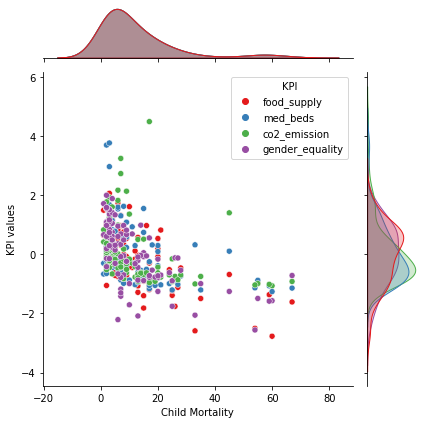

In [53]:
merged_df_melted = pd.melt(norm_merged_df, id_vars='child_mortality', value_vars=['food_supply', 'med_beds', 'co2_emission', 'gender_equality'], var_name='KPI')

g = sns.jointplot(data=merged_df_melted, x='child_mortality', y='value', hue='KPI', palette='Set1', kind='scatter')
g.set_axis_labels('Child Mortality', 'KPI values')
plt.tight_layout()
plt.show()

In [54]:
norm_merged_df.to_csv('./analysis_data/analysis_data_normalized.csv')